### Predicting temperature

In this exercise, you'll work with historical temperature data from the Szeged, Hungary area. The dataset you'll use is a Postgres database version of [this dataset from Kaggle](https://www.kaggle.com/budincsevity/szeged-weather/home). To complete this assignment, submit a Jupyter notebook containing your solutions to the following tasks:

* First, load the dataset from the **weatherinszeged** table from Thinkful's database.
* Build a regression model where the target variable is *temperature*. As explanatory variables, use *humidity*, *windspeed*, *windbearing*, and *pressure*. Estimate the model using OLS.
* Now, check if your model meets the Gauss-Markov Conditions above. If some of the assumptions are not met, discuss the implications of the violations for the correctness of your model.

In [68]:
import numpy as np
import pandas as pd
from sklearn import linear_model
from scipy.stats import boxcox

from sklearn.preprocessing import minmax_scale
# from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale

import statsmodels
from scipy.stats import boxcox

import statsmodels.api as sm
from math import ceil


import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine

import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_rows = 999
pd.set_option('display.max_columns', 500)

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'weatherinszeged'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

weather = pd.read_sql_query('select * from weatherinszeged',con=engine)

engine.dispose()

In [4]:
weather.head()

,date,summary,preciptype,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure,dailysummary
0,2006-03-31 22:00:00+00:00,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-03-31 23:00:00+00:00,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 00:00:00+00:00,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 01:00:00+00:00,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 02:00:00+00:00,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [5]:
# this dataset has a huge number of columns
weather.shape

(96453, 12)

In [11]:
weather.loc[:,'humidity':'windbearing'].columns

Index(['humidity', 'windspeed', 'windbearing'], dtype='object')

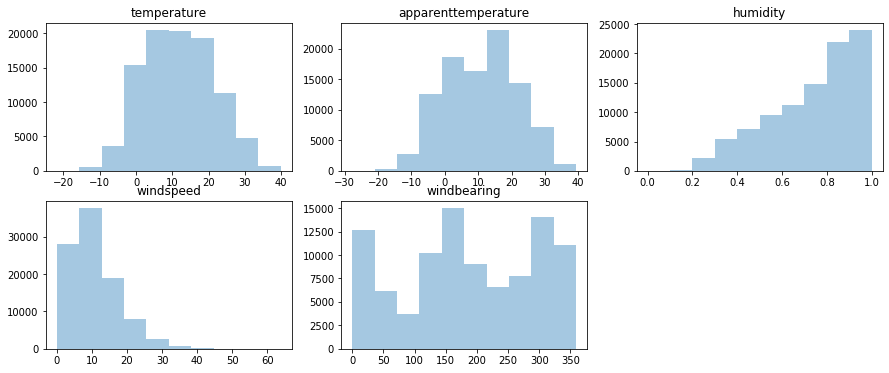

In [46]:
# examine features with histograms
fig = plt.figure(figsize=(15, 6))

for i, column in enumerate(weather.loc[:,'temperature':'windbearing'].columns):
    plt.subplot(ceil(len(weather.loc[:,'temperature':'windbearing'].columns)/3), 3, i+1)
    plt.title(column)
    plt.hist(weather[column], alpha=.4);

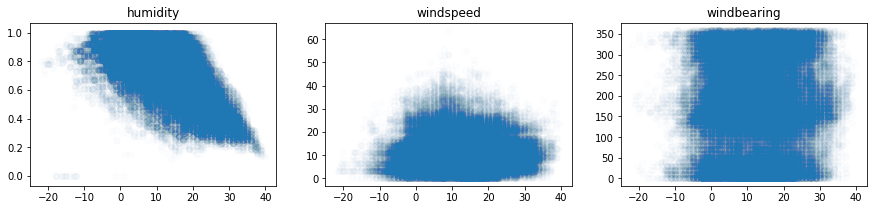

In [23]:
# examine features against
# target variable
fig = plt.figure(figsize=(15, 3))

for i, column in enumerate(weather.loc[:,'humidity':'windbearing'].columns):
    plt.subplot(ceil(len(weather.loc[:,'humidity':'windbearing'].columns)/3), 3, i+1)
    plt.title(column)
    plt.scatter(weather.temperature, weather[column], alpha=.01);

### Model Fitting

In [38]:
# using sklearn
# Y is the target variable
Y = weather.temperature
# X is the feature set which includes
# is_male and is_smoker variables
X = weather.loc[:,'humidity':'windbearing']

# We create a LinearRegression model object
# from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [-3.24938597e+01 -2.00829865e-01  4.05324251e-03]

Intercept: 
 37.22346138000694


In [35]:
# using statsmodel

# We need to manually add a constant
# in statsmodels' sm
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            temperature   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                 2.333e+04
Date:                Mon, 11 Nov 2019   Prob (F-statistic):               0.00
Time:                        16:17:18   Log-Likelihood:            -3.2821e+05
No. Observations:               96453   AIC:                         6.564e+05
Df Residuals:                   96449   BIC:                         6.565e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          37.2235      0.113    328.225      0.000      37.001      37.446
humidity      -32.4939      0.123   -264.258      0.000     -32.735     -32.253
windspeed      -0.2008      0.003    -57.454      0.000      -0.208      -0.194
windbearing     0.0041      0.000     18.484      0.000       0.004       0.004
==============================================================================
Omnibus:                     3369.868   Durbin-Watson:                   0.059
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3785.307
Skew:                          -0.455   Prob(JB):                         0.00
Kurtosis:                       3.337   Cond. No.                     1.49e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.49e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Gauss Markov Conditions to consider:

* linearity of models in their coefficients
* the error term should be zero on average
* homoscedasticity
* low multicollinearity
* error terms should be uncorrelated with one another
* features shouldn't be correlated with the errors
* normality of the errors


#### 1. linearity of models in their coefficients

In principle, this assumption is not related to estimation but to how we specify our model. So as long as we use models that take into account this linearity assumption as we did in our medical costs example, then we shouldn't worry about this assumption at all.

#### 2. the error term should be zero on average


In [39]:
predictions = lrm.predict(X)
errors = Y - predictions

print("Mean of the errors in the medical costs model is: {}".format(np.mean(errors)))

Mean of the errors in the medical costs model is: -8.203585067778582e-16


Since I have included the constant term in the model, the average of the model's error is effectively zero.

#### 3. homoscedasticity - the distribution of its error terms (known as "scedasticity") is consistent for all predicted values

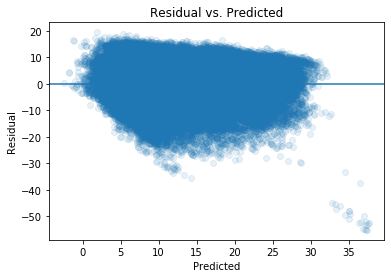

In [40]:
plt.scatter(predictions, errors, alpha=.1)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

Visually, it appears that more of the error is distributed farther below the horizontal line at zero.

In [41]:
from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 2469.35 and p value is 0
Levene test statistic value is 2330.89 and p value is 0


The p-values of both tests are lower than 0.05. So, the test results reject the null hypothesis which means our errors are heteroscedastic, meaning they aren't distributed equally

<font color=red> Some fixes to heteroscedasticity include transforming the dependent variable (see [Box Cox transformation](https://www.statisticshowto.datasciencecentral.com/box-cox-transformation/) and [log transformation](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4120293/)) and adding features that target the poorly-estimated areas.</font>

(array([   54.,   494.,  3550., 15397., 20497., 20322., 19286., 11334.,
         4833.,   686.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

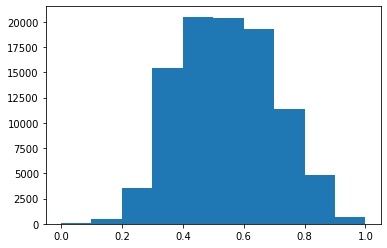

In [69]:
# scale temperature to between 0 - 1 
# so that I can apply box-cox

plt.hist(minmax_scale(weather.temperature, feature_range=(0,1)))

In [87]:
# boxcox still requires it to be greater than 
# zero since zero is not positive
y,_ = boxcox(minmax_scale(weather.temperature, feature_range=(.0001,1)))

In [88]:
y,_

(array([-0.52333743, -0.52549695, -0.52508549, ..., -0.29874865,
        -0.30770751, -0.32656056]), 0.8041322818354633)

In [89]:
pd.Series(y).head()

0   -0.523337
1   -0.525497
2   -0.525085
3   -0.545315
4   -0.536628
dtype: float64

In [90]:
# apply Box Cox to the target variable to see
# if it reduces the heteroscedasticity of the data

# Y is the target variable
Y = y
# X is the feature set which includes
X = weather.loc[:,'humidity':'windbearing']

# We create a LinearRegression model object
# from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [-5.86559167e-01 -3.56520646e-03  7.57231217e-05]

Intercept: 
 -0.027753861613486974


In [91]:
# now examine to see if data is
# homoscedastic
from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 2469.35 and p value is 0
Levene test statistic value is 2330.89 and p value is 0


### <font color=red>I'm still not able to get the data homoscedastic, even after using Box-Cox transformation on the target variable.</font>

#### 4. low multicollinearity

In [92]:
# check to see how correlated the features I have selected are
X.corr().iloc[:,1].sort_values(ascending=False)

windspeed      1.000000
windbearing    0.103822
humidity      -0.224951
Name: windspeed, dtype: float64

(3.0, 0.0)

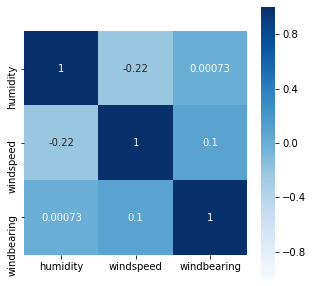

In [94]:
# compare features using a heatmap
plt.figure(figsize=(5, 5))

ax = sns.heatmap(X.corr(), 
                 vmin=-1, vmax=1, center=0, 
                 square=True, annot=True, 
                 cmap="Blues")

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

#### 5. error terms should be uncorrelated with one another


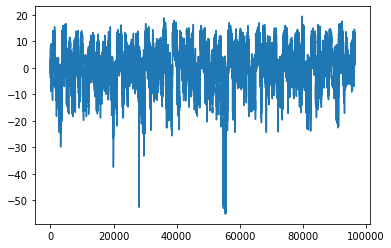

In [96]:
# error is the y axis
# index is the x axis
plt.plot(errors)

Error terms seem to be weighted towards negative numbers.

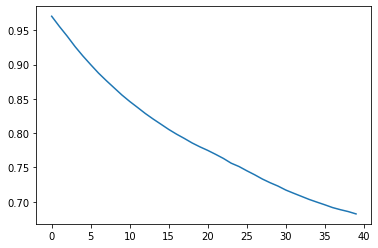

In [97]:
# check using autocorrelation function from statsmodels

from statsmodels.tsa.stattools import acf

acf_data = acf(errors)

plt.plot(acf_data[1:])

### <font color=red>I'm not sure how to interpret this. What do the x and y mean here?</font>

Dustin - also recommended the Durbin-Watson test to check for this
https://www.statisticshowto.datasciencecentral.com/durbin-watson-test-coefficient/

#### 6. features shouldn't be correlated with the errors


Arguably the most important assumption: explanatory variables and errors should be independent. If this assumption doesn't hold, then the model's predictions will be unreliable as the estimates of the coefficients would be biased. This assumption is known as the **exogeneity**.

Violations of the exogeneity assumption may have several sources. Common causes are omitted variables and simultaneous causation between independent variables and the target. If the problem stems from simultaneous causation then we need to apply some advanced techniques to solve for the issue but this is beyond the scope of this bootcamp.

#### 7. normality of the errors

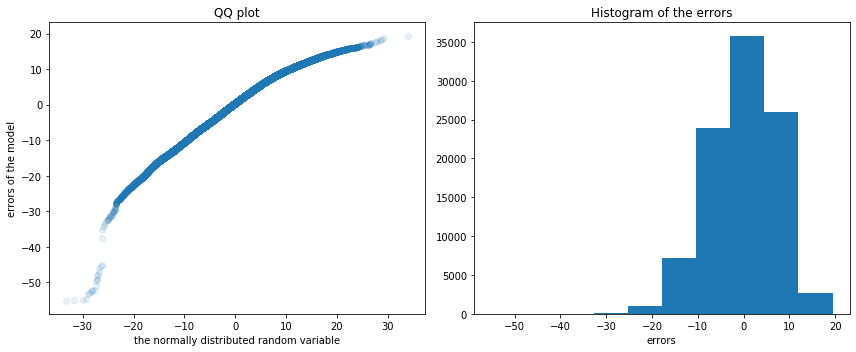

In [103]:
# check for the normality of the errors
rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(np.sort(rand_nums), np.sort(errors), alpha=.1) # we sort the arrays
plt.xlabel("the normally distributed random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")

plt.subplot(1,2,2)
plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")

plt.tight_layout()

The errors seems to be weighted towards negative values.

Dustin recommends running QQ plot from statsmodels
https://www.statsmodels.org/stable/generated/statsmodels.graphics.gofplots.qqplot.html

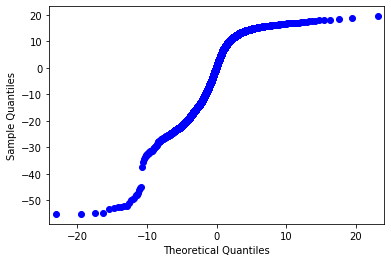

In [113]:
import statsmodels.api as sm
import scipy.stats as stats

fig = sm.qqplot(errors, stats.t, distargs=(4,))

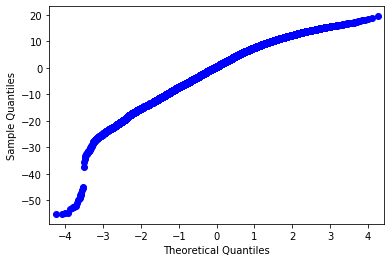

In [114]:
fig = sm.qqplot(errors)

Why are the shapes of these two so different?

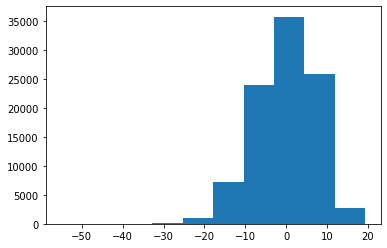

In [117]:
# examine a histogram for normality
plt.hist(errors);

It doesn't look normal since it has a tail.

In [115]:
# check for normality using statistical tests

from scipy.stats import jarque_bera
from scipy.stats import normaltest
jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 3785.306587050703 and p value is 0.0
Normality test statistics is 3369.868202137006 and p value is 0.0


The super small p-value result from each of these tests indicate that my errors are not normally distributed.

### Examining Estimated Coefficients

1. Build a linear regression model where your target variable is the difference between the *apparenttemperature* and the *temperature*. As explanatory variables, use *humidity* and *windspeed*. 
 - Now, estimate your model using OLS. Are the estimated coefficients statistically significant? 
     - Yes, both humidity and windspeed are statistically significant.
 - Are the signs of the estimated coefficients in line with your previous expectations? Interpret the estimated coefficients. 
     - Yes, as temperature decreases, both humidity and windspeed increase.  This makes intuitive sense.
 - What are the relations between the target and the explanatory variables? 
     - As temperature decreases, both humidity and windspeed increase.
2. Next, include the interaction of *humidity* and *windspeed* to the model above and estimate the model using OLS. Are the coefficients statistically significant? Did the signs of the estimated coefficients for *humidity* and *windspeed* change? Interpret the estimated coefficients.
 - The coefficients are statistically significant
 - The signs for both humidity and windspeed changed from negative to positive
 - Together humidity and windspeed are negatively correlated with temperature, however on their own, an increase in both windspeed and humidity contribute to an increase in temperature.

In [129]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'weatherinszeged'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

weather = pd.read_sql_query('select * from weatherinszeged',con=engine)

engine.dispose()

In [123]:
# using sklearn
# Y is the target variable
Y = weather.apparenttemperature - weather.temperature
# X is the feature set which includes
# is_male and is_smoker variables
X = weather.loc[:,'humidity':'windspeed']

# We create a LinearRegression model object
# from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [-3.02918594 -0.11929075]

Intercept: 
 2.4381054151876995


In [125]:
# using statsmodel
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.288
Method:                 Least Squares   F-statistic:                 1.949e+04
Date:                Mon, 11 Nov 2019   Prob (F-statistic):               0.00
Time:                        18:04:52   Log-Likelihood:            -1.7046e+05
No. Observations:               96453   AIC:                         3.409e+05
Df Residuals:                   96450   BIC:                         3.409e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4381      0.021    115.948      0.000       2.397       2.479
humidity      -3.0292      0.024   -126.479      0.000      -3.076      -2.982
windspeed     -0.1193      0.001   -176.164      0.000      -0.121      -0.118
==============================================================================
Omnibus:                     3935.747   Durbin-Watson:                   0.267
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4613.311
Skew:                          -0.478   Prob(JB):                         0.00
Kurtosis:                       3.484   Cond. No.                         88.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Interaction of *humidity* and *windspeed* added

In [118]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'weatherinszeged'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

weather = pd.read_sql_query('select * from weatherinszeged',con=engine)

engine.dispose()

In [137]:
# using sklearn
# Y is the target variable
Y = weather.apparenttemperature - weather.temperature

# X is the feature set which includes
# humidity, weather, and interaction
X = pd.concat([weather.loc[:,'humidity':'windspeed'], (weather.humidity * weather.windspeed)], axis=1).rename(columns={0: "hum_wind"})

# We create a LinearRegression model object
# from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [ 0.17751219  0.09048213 -0.29711946]

Intercept: 
 0.08393631009782343


In [138]:
# using statsmodel
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.341
Model:                            OLS   Adj. R-squared:                  0.341
Method:                 Least Squares   F-statistic:                 1.666e+04
Date:                Mon, 11 Nov 2019   Prob (F-statistic):               0.00
Time:                        19:16:05   Log-Likelihood:            -1.6669e+05
No. Observations:               96453   AIC:                         3.334e+05
Df Residuals:                   96449   BIC:                         3.334e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0839      0.033      2.511      0.012       0.018       0.149
humidity       0.1775      0.043      4.133      0.000       0.093       0.262
windspeed      0.0905      0.002     36.797      0.000       0.086       0.095
hum_wind      -0.2971      0.003    -88.470      0.000      -0.304      -0.291
==============================================================================
Omnibus:                     4849.937   Durbin-Watson:                   0.265
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9295.404
Skew:                          -0.378   Prob(JB):                         0.00
Kurtosis:                       4.320   Cond. No.                         193.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""